# Telco Churn Analysis
by Ben Bellman 
Dataset from Kaggle -- https://www.kaggle.com/blastchar/telco-customer-churn/code

![image.png](./../images/istockphoto-1188462768-1024x1024.jpg)

### Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

### Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

## Inspiration
To explore this type of models and learn more about the subject.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from skopt import BayesSearchCV

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from xgboost import XGBClassifier


from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss,matthews_corrcoef, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
## Load Data and Preview
churn = pd.read_csv('.\..\datasets\Telco_Dataset.csv')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
## Get Info on churn:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


There is no missing data however, churn and total_charges are not as the right type. Let's look at the column compositions:

In [4]:
## Convert TotalCharges and Churn to floats and ints, respectively. 
churn.TotalCharges = churn.TotalCharges.replace(' ',0)
churn.TotalCharges = churn.TotalCharges.astype(float, errors= 'raise')

churn.Churn = np.where(churn.Churn == "No",0,1)
churn.TotalCharges = churn.TotalCharges.astype(float, errors= 'raise')

In [5]:
## Get dummy columns for categorical variables. 
dummy_cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',
              'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
             'Contract','PaperlessBilling','PaymentMethod']

dummies = pd.get_dummies(churn.loc[:,dummy_cols], drop_first = True)

In [6]:
## Replace previous dummy cols with new cols. 
churn.drop(columns = dummy_cols,inplace = True)
churn = pd.concat([churn,dummies],axis = 1)
churn.sample(5)

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2683,8128-YVJRG,7,79.65,604.70,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3102,0516-WJVXC,5,54.20,308.25,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4956,3217-FZDMN,8,94.45,742.95,1,1,0,0,0,1,...,0,1,0,1,0,0,1,1,0,0
5822,9112-WSNPU,35,70.55,2419.00,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6472,1150-FTQGN,60,94.15,5811.80,0,0,0,1,1,1,...,0,1,0,0,1,0,0,0,0,0


In [7]:
## Drop CustomerId
churn.drop(columns='customerID',inplace = True)

In [8]:
## Scaled Our Columns using MinMaxScaler()
cols_scale = ['MonthlyCharges','TotalCharges','tenure']

scaler = MinMaxScaler()
scaler.fit(churn[cols_scale])

churn_scaled = scaler.transform(churn[cols_scale])
for ind , col in enumerate(cols_scale):
    churn[col] = churn_scaled[:,ind]
churn.head()

,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.013889,0.115423,0.003437,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0.472222,0.385075,0.217564,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0.027778,0.354229,0.012453,1,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0.625000,0.239303,0.211951,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.027778,0.521891,0.017462,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [9]:
## Make Churn our First Column
target = churn.Churn
churn.drop(columns='Churn',inplace = True)
churn = pd.concat([target,churn], axis = 1)
churn.sample(5)

,Churn,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5047,0,0.541667,0.546269,0.314440,0,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1703,0,0.152778,0.173134,0.048948,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4051,0,1.000000,0.790547,0.791003,0,0,1,0,1,0,...,0,1,0,1,0,1,1,1,0,0
4958,0,0.819444,0.761194,0.644534,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,1,0
6742,0,0.722222,0.606468,0.462452,0,1,1,1,1,0,...,0,1,0,1,0,1,0,0,1,0


## EDA 

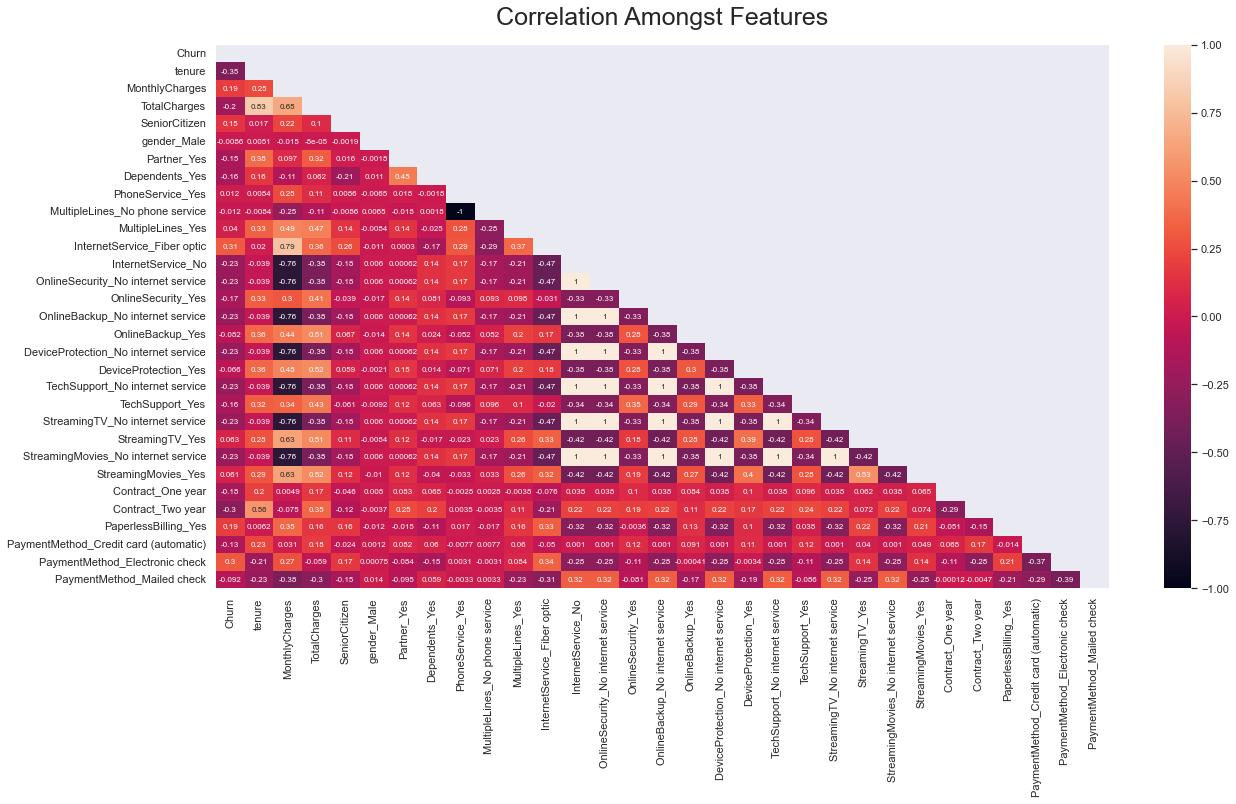

In [10]:
## Preparing EDA: 
plt.figure(figsize=(20,10))
sns.heatmap(churn.corr(), mask = np.triu(churn.corr()), annot = True, annot_kws={"size":8} )
plt.title('Correlation Amongst Features', fontsize =25, pad =20)
plt.show()

## Preprocessing:

In [11]:
## We get our features and create a training and test set.   
X = churn.drop(columns='Churn')
y = churn.Churn
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

In [12]:
## Our churn customers are in the minority, so we need to resample the training data 
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)
X_train , y_train = oversample.fit_resample(X_train, y_train)

## Modelling

#### 1. LogisticRegression

In [13]:
## We instantiate a logistic regression model and use GridSearchCV to find the best parameters. 
'''
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1],
             'penalty':['none','l1','l2','elasticnet']
             }
lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
lr_cv.fit(X_train,y_train)

## We print the metrics: 
print('Best Params:' +str(lr_cv.best_params_))

############################################ GRIDSEARCHCV_RESULTS ################################################## 

## Scoring = 'roc_auc':
'''

'''
Best Params:{'C': 100, 'l1_ratio': 0, 'penalty': 'l2'}
'''

######################################################################################################################

## With the best parameters, we re-instantiate the model, fit and predict the outcomes. 
best_lreg = LogisticRegression(C = 0.001, l1_ratio= 0, penalty = 'l2')

#### 2) RandomForest

In [14]:
## We use GridSearchCV to find the best hyperparameters of RandomForest. 
'''
rfc = RandomForestClassifier(random_state = 42)

params = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": (1, 9),
    "criterion": ["gini", "entropy"],
}

search = BayesSearchCV(
    estimator=rfc,
    search_spaces=params,
    n_jobs=1,
    cv=5,
    n_iter=30,
    scoring="roc_auc",
    verbose=4,
    random_state=42
)

search.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 

print('Best Params:' +str(search.best_params_))
'''
############################################ GRIDSEARCHCV_RESULTS ################################################## 

## Scoring = 'roc_auc': 
'''
Best Params:OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('n_estimators', 400)])
'''

######################################################################################################################

## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
rfc_best = RandomForestClassifier(bootstrap= False, criterion= 'gini', max_depth= 9, 
                                  n_estimators= 400, random_state = 42)

#### 3) GradientBoosting

In [15]:
## We use GridSearchCV to find the best hyperparameters for Gradient Boosting
'''
gbc = GradientBoostingClassifier(random_state = 42)
param_grid = { 
    'loss': ['exponential','deviance'],
    'n_estimators': [1,2,5,10,20,100],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth' : [2,3,4,5,6,8,10],
}

gbc_GS = RandomizedSearchCV(gbc, param_grid, cv=5, scoring='roc_auc', random_state = 42)
gbc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Params:' +str(gbc_GS.best_params_))
'''


############################################ RandomizedSEARCHCV_RESULTS ################################################## 

## Scoring = 'roc_auc': 
'''
Best Params:{'n_estimators': 5, 'max_depth': 6, 'loss': 'exponential', 'criterion': 'squared_error'}
'''
######################################################################################################################

## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
gbc_best = GradientBoostingClassifier(loss = 'exponential', max_depth = 6, n_estimators = 5,
                                      criterion = 'squared_error', random_state = 42)

#### 4) AdaBoost

In [16]:
'''
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),random_state=42)

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

ada_GS = RandomizedSearchCV(ada, parameters,verbose=3,scoring='roc_auc',n_jobs=-1, random_state = 42)
ada_GS.fit(X_train,y_train)

print('Best Params:' +str(ada_GS.best_params_))

############################################ GRIDSEARCHCV_RESULTS ################################################## 
'''
## Scoring = 'roc_auc': 
'''

Best Params:{'n_estimators': 250, 'learning_rate': 0.01, 'base_estimator__min_samples_leaf': 10, 
             'base_estimator__max_depth': 2}

'''
ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, min_samples_leaf=10,random_state=42),
                                                           learning_rate=0.01, n_estimators=250, random_state=42)

#### 5) K-Neighbors

In [17]:
'''
knn = KNeighborsClassifier()

#List Hyperparameters that we want to tune.
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(knn, grid_params, verbose = 1, cv=3, n_jobs = -1, scoring ='roc_auc')
g_res = gs.fit(X_train, y_train)

#Print The value of best Hyperparameters
print('Best parameters: {}'.format(g_res.best_params_))
'''
############################################ GRIDSEARCHCV_RESULTS ################################################## 

## Scoring = 'roc_auc': 
'''
Best parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
'''

knn_best = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 15, weights = 'distance')

#### 6) XGBoost

In [18]:
## With XGBoost
model = XGBClassifier(random_state = 42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy_score(y_test, preds)

[12:53:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7728563316297559

In [19]:
params= {
    'learning_rate': [0.05,0.1,0.15,0.2,0.25,0.3], 
    'max_depth': [3,4,5,6,8,10,12,15],
    'min_child_weight': [1,3,5,7],
    'gamma': [0,0.1,0.2,0.3,0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}

xgb = XGBClassifier(random_state =42)

random_search = RandomizedSearchCV(xgb, param_distributions = params , n_iter =5, scoring ='roc_auc', n_jobs =-1, cv=2,
                                  verbose=3)

random_search.fit(X_train,y_train)
random_search.best_params_

xgb_best = XGBClassifier(min_child_weight = 1,
 max_depth= 15,
 learning_rate= 0.2,
 gamma= 0.4,
 colsample_bytree=0.42, random_state =42)

xgb_best.fit(X_train, y_train)
preds = xgb_best.predict(X_test)
accuracy_score(y_test, preds)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[12:53:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7688813174332766

## Results: 

#### 1. Visualizing ROC_AUC Curve

[12:54:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


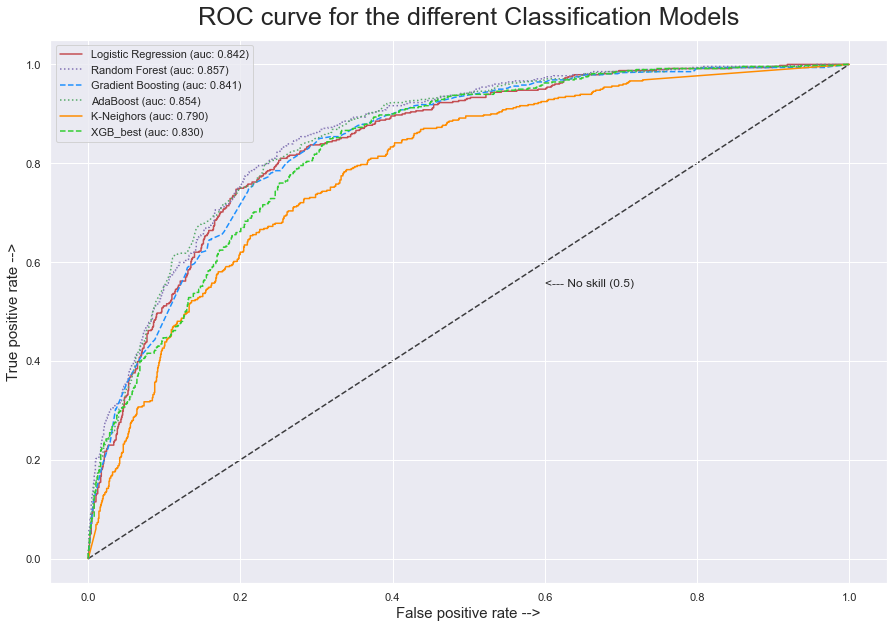

In [20]:
## We plot the ROC and AUC 
names = ["Logistic Regression","Random Forest","Gradient Boosting",'AdaBoost',"K-Neighors",'XGB_best']
clfs = [best_lreg,rfc_best,gbc_best,ada_best,knn_best,xgb_best]

## Parameters for the plotting 
linestyles =['-',':','--',':','-','--',':','-','-']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink','navy','y']

plt.figure(figsize=(15,10))
counter = 0
for name,clf in zip(names,clfs):
    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    #print("Roc AUC:"+name, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro')) ## Can uncomment
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name+ ' (auc: %0.3f)' %roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro'),
             linestyle=linestyles[counter], c=colors[counter])
    counter += 1
## Plot a straight line that goes throug
lims = [np.min([0.0, 0.0]),  np.max([1.0, 1.0])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='black', linestyle ='--')

plt.xlabel('False positive rate -->', fontsize = 15)
plt.ylabel('True positive rate -->', fontsize = 15)
plt.title('ROC curve for the different Classification Models', pad =15, fontsize = 25)
plt.legend(loc='best')
plt.savefig('roc_auc_classification_4_models_resampling.png')
plt.annotate('<--- No skill (0.5)',xy=(0.6,0.55))
plt.show() 

#### 2. Visualizing Precision_Recall Tradeoff Curve

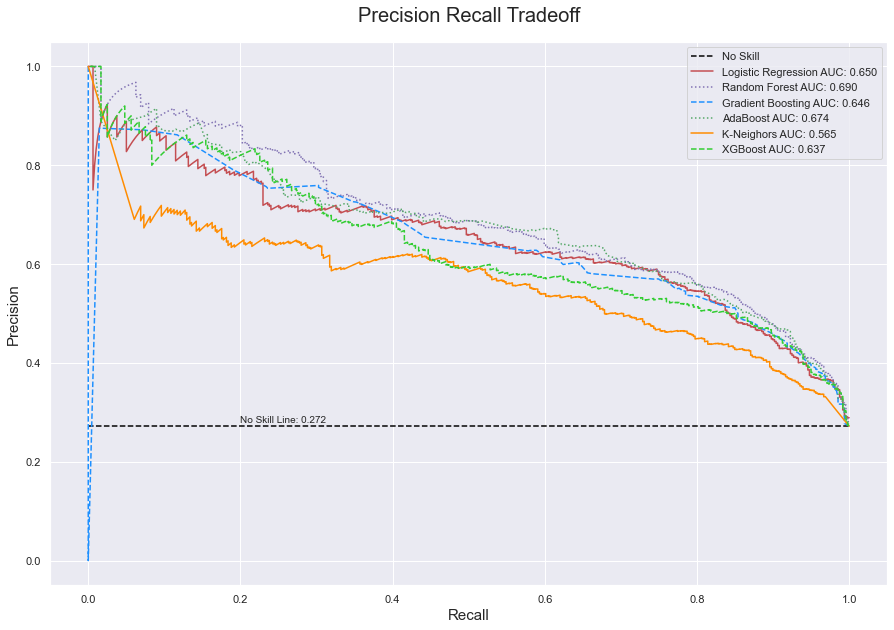

In [21]:
## Plotting the Precision / Recall Tradeoff 

names = ["Logistic Regression","Random Forest","Gradient Boosting",'AdaBoost',"K-Neighors",'XGBoost']
models = [best_lreg,rfc_best,gbc_best,ada_best,knn_best,xgb_best]

linestyles =['-',':','--',':','-','--',':','-','-']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink','navy','y']

plt.figure(figsize=(15,10))

## Plotting the no-skill line. 
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', c='black')

counter = 0
for name, model in zip(names,models):
    precision,recall,thresholds = precision_recall_curve(y_test,model.predict_proba(X_test)[:,1])
    plt.plot(recall,precision,color=colors[counter], 
             linestyle=linestyles[counter], 
             label = name  +' AUC: %.3f'%auc(recall,precision))
    counter +=1


plt.title('Precision Recall Tradeoff', pad=20, fontsize = 20)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.annotate('No Skill Line: '+str(round(no_skill,3)),(0.2,0.28), fontsize =10)
plt.legend()
plt.savefig('precision_recall_4_models_resampling.png')
plt.show()

#### 3. Evaluating Model Metrics and Plotting Confusion Matrices: 

Gradient Boosting Model Metrics:
ROC_AUC_SCORE: 0.841
Accuracy: 0.738
Precision: 0.511
Recall: 0.848
F1-Score: 0.638
Log Loss Score: 9.042
MCC: 0.487


Random Forest Model Metrics:
ROC_AUC_SCORE: 0.857
Accuracy: 0.773
Precision: 0.558
Recall: 0.806
F1-Score: 0.659
Log Loss Score: 7.826
MCC: 0.517


Logistic Regression Model Metrics:
ROC_AUC_SCORE: 0.842
Accuracy: 0.741
Precision: 0.515
Recall: 0.837
F1-Score: 0.638
Log Loss Score: 8.944
MCC: 0.486


AdaBoost Model Metrics:
ROC_AUC_SCORE: 0.854
Accuracy: 0.743
Precision: 0.517
Recall: 0.846
F1-Score: 0.641
Log Loss Score: 8.885
MCC: 0.492


K-Neighbors Model Metrics:
ROC_AUC_SCORE: 0.79
Accuracy: 0.698
Precision: 0.466
Recall: 0.752
F1-Score: 0.576
Log Loss Score: 10.415
MCC: 0.386


[12:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

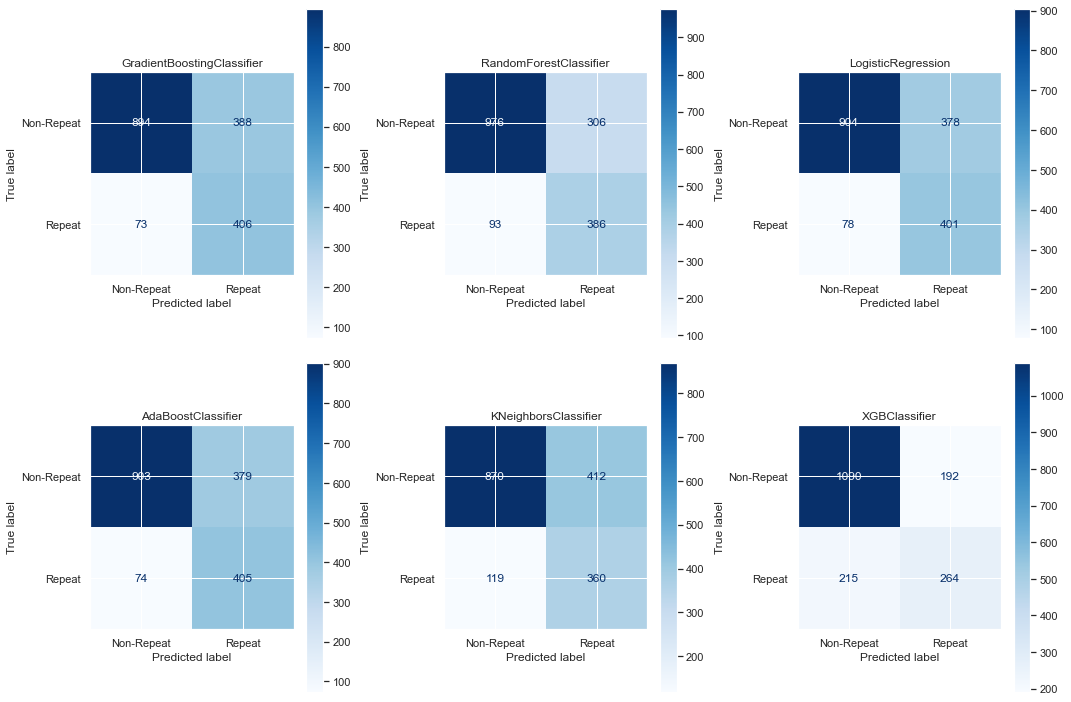

In [22]:
names = ["Gradient Boosting","Random Forest","Logistic Regression","AdaBoost","K-Neighbors",'XGBoost']
models = [gbc_best,rfc_best,best_lreg,ada_best,knn_best,xgb_best]

counter = 0
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('{} Model Metrics:'.format(names[counter]))
    print('ROC_AUC_SCORE: ' + str(round(roc_auc,3)))
    print('Accuracy: ' + str(round(accuracy_score(y_test,y_pred),3)))
    print('Precision: '+ str(round(precision_score(y_test,y_pred),3)))
    print('Recall: ' + str(round(recall_score(y_test,y_pred),3)))
    print('F1-Score: ' + str(round(f1_score(y_test,y_pred),3)))
    print('Log Loss Score: ' + str(round(log_loss(y_test,y_pred),3)))
    print('MCC: ' + str(round(matthews_corrcoef(y_test,y_pred),3)))
    print("\n")
    counter +=1
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(model, 
                            X_test, 
                            y_test, 
                            ax=ax, 
                            cmap='Blues',
                            display_labels=['Non-Repeat','Repeat'])
    ax.title.set_text(type(model).__name__)

plt.tight_layout()  
plt.show()

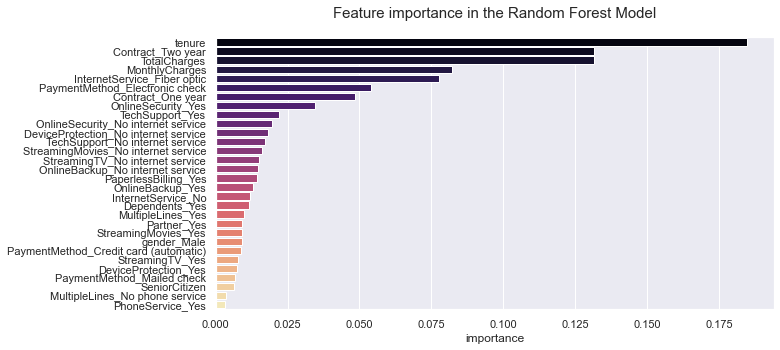

In [23]:
## Feature Importance: 
features_best = pd.DataFrame(rfc_best.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
features_best

plt.figure(figsize=(10,5))
sns.color_palette("magma", as_cmap=True)
sns.barplot(y = features_best.index, x = features_best['importance'],palette='magma')
plt.title('Feature importance in the Random Forest Model', pad = 20, fontsize = 15)
plt.show()